# Julia is fast

Very often, benchmarks are used to compare languages.  These benchmarks can lead to long discussions, first as to exactly what is being benchmarked and secondly what explains the differences.  These simple questions can sometimes get more complicated than you at first might imagine.

The purpose of this notebook is for you to see a simple benchmark for yourself.  One can read the notebook and see what happened on the author's Macbook Pro with a 4-core Intel Core I7, or run the notebook yourself.

(This material began life as a wonderful lecture by Steven Johnson at MIT: https://github.com/stevengj/18S096/blob/master/lectures/lecture1/Boxes-and-registers.ipynb.)

# Outline of this notebook

- Define the sum function
- Implementations & benchmarking of sum in...
    - C (hand-written)
    - C (hand-written with -ffast-math)
    - python (built-in)
    - python (numpy)
    - python (hand-written)
    - Julia (built-in)
    - Julia (hand-written)
    - Julia (hand-written with SIMD)
- Summary of benchmarks

# `sum`: An easy enough function to understand

Consider the  **sum** function `sum(a)`, which computes
$$
\mathrm{sum}(a) = \sum_{i=1}^n a_i,
$$
where $n$ is the length of `a`.

In [1]:
a = rand(10^7) # 1D vector of random numbers, uniform on [0,1)

10000000-element Vector{Float64}:
 0.5566369207359326
 0.9702412700359914
 0.4010526752597634
 0.5845790752738748
 0.37949546800753564
 0.5794614560159694
 0.9559772561590725
 0.3982247880432124
 0.7047615396003212
 0.18214871047761771
 ⋮
 0.7052082496865029
 0.7698283711993459
 0.03545519128126362
 0.9661995726615692
 0.1570809358618077
 0.5722456114997698
 0.9001421570329836
 0.7382527641097762
 0.2546971668623913

In [2]:
sum(a)

5.000191386831239e6

The expected result is 0.5 * 10^7, since the mean of each entry is 0.5

# Benchmarking a few ways in a few languages

In [3]:
@time sum(a)

  0.005059 seconds (1 allocation: 16 bytes)


5.000191386831239e6

In [4]:
@time sum(a)

  0.005128 seconds (1 allocation: 16 bytes)


5.000191386831239e6

In [5]:
@time sum(a)

  0.004223 seconds (1 allocation: 16 bytes)


5.000191386831239e6

The `@time` macro can yield noisy results, so it's not our best choice for benchmarking!

Luckily, Julia has a `BenchmarkTools.jl` package to make benchmarking easy and accurate:

In [6]:
using Pkg
Pkg.add("BenchmarkTools")

   Resolving package versions...
  No Changes to `C:\Users\apaul314\.julia\environments\v1.10\Project.toml`
  No Changes to `C:\Users\apaul314\.julia\environments\v1.10\Manifest.toml`


In [7]:
using BenchmarkTools  

#  1. The C language

C is often considered the gold standard: difficult on the human, nice for the machine. Getting within a factor of 2 of C is often satisfying. Nonetheless, even within C, there are many kinds of optimizations possible that a naive C writer may or may not get the advantage of.

The current author does not speak C, so he does not read the cell below, but is happy to know that you can put C code in a Julia session, compile it, and run it. Note that the `"""` wrap a multi-line string.

In [8]:
using Libdl
C_code = """
#include <stddef.h>
double c_sum(size_t n, double *X) {
    double s = 0.0;
    for (size_t i = 0; i < n; ++i) {
        s += X[i];
    }
    return s;
}
"""

const Clib = tempname()   # make a temporary file


# compile to a shared library by piping C_code to gcc
# (works only if you have gcc installed):

open(`gcc -fPIC -O3 -msse3 -xc -shared -o $(Clib * "." * Libdl.dlext) -`, "w") do f
    print(f, C_code) 
end

# define a Julia function that calls the C function:
c_sum(X::Array{Float64}) = ccall(("c_sum", Clib), Float64, (Csize_t, Ptr{Float64}), length(X), X)

c_sum (generic function with 1 method)

In [9]:
c_sum(a)

5.000191386831326e6

In [10]:
c_sum(a) ≈ sum(a) # type \approx and then <TAB> to get the ≈ symbolb

true

In [11]:
c_sum(a) - sum(a)  

8.754432201385498e-8

In [12]:
≈  # alias for the `isapprox` function

isapprox (generic function with 13 methods)

In [13]:
?isapprox

Base.Meta.ParseError: ParseError:
# Error @ c:\Users\apaul314\Desktop\JULIA_TUTORIAL\Introduction-to-Julia\9 - Julia is fast.ipynb:1:1
?isapprox
╙ ── not a unary operator

We can now benchmark the C code directly from Julia:

In [14]:
c_bench = @benchmark c_sum($a)

BenchmarkTools.Trial: 500 samples with 1 evaluation.
 Range (min … max):  9.744 ms …  11.995 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     9.901 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   9.979 ms ± 269.588 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

    ▅▄█▁▁▂▁                                                    
  ▄▇███████▅▇█▆▆▄▄▅▄▄▄▄▃▃▃▂▃▃▂▂▂▂▃▂▂▃▁▂▁▂▂▂▁▁▂▂▁▁▂▂▁▁▂▂▁▁▁▁▁▂ ▃
  9.74 ms         Histogram: frequency by time        10.9 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [15]:
println("C: Fastest time was $(minimum(c_bench.times) / 1e6) msec")

C: Fastest time was 9.7436 msec


In [16]:
d = Dict()  # a "dictionary", i.e. an associative array
d["C"] = minimum(c_bench.times) / 1e6  # in milliseconds
d

Dict{Any, Any} with 1 entry:
  "C" => 9.7436

In [17]:
using Plots
gr()

Plots.GRBackend()

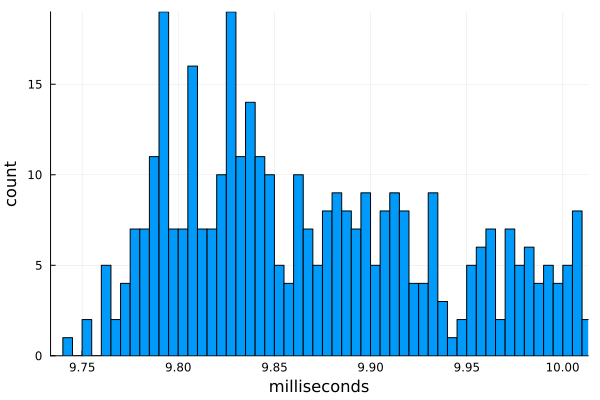

In [18]:
using Statistics # bring in statistical support for standard deviations
t = c_bench.times / 1e6 # times in milliseconds
m, σ = minimum(t), std(t)

histogram(t, bins=500,
    xlim=(m - 0.01, m + σ),
    xlabel="milliseconds", ylabel="count", label="")

# 2. C with -ffast-math

If we allow C to re-arrange the floating point operations, then it'll vectorize with SIMD (single instruction, multiple data) instructions.

In [19]:
const Clib_fastmath = tempname()   # make a temporary file

# The same as above but with a -ffast-math flag added
open(`gcc -fPIC -O3 -msse3 -xc -shared -ffast-math -o $(Clib_fastmath * "." * Libdl.dlext) -`, "w") do f
    print(f, C_code) 
end

# define a Julia function that calls the C function:
c_sum_fastmath(X::Array{Float64}) = ccall(("c_sum", Clib_fastmath), Float64, (Csize_t, Ptr{Float64}), length(X), X)

c_sum_fastmath (generic function with 1 method)

In [20]:
c_fastmath_bench = @benchmark $c_sum_fastmath($a)

BenchmarkTools.Trial: 851 samples with 1 evaluation.
 Range (min … max):  5.474 ms …   8.020 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     5.727 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   5.868 ms ± 371.018 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

    ▄█▇▇▇▃ ▁                                                   
  ▃▅██████████▇▅▄▅▄▇▅▆▄▅▅▆▃▄▄▄▃▄▃▂▄▃▃▃▃▂▂▃▁▂▂▃▂▃▃▁▂▁▁▂▃▁▂▂▂▂▂ ▄
  5.47 ms         Histogram: frequency by time         7.2 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [21]:
d["C -ffast-math"] = minimum(c_fastmath_bench.times) / 1e6  # in milliseconds

5.4737

# 3. Python's built in `sum` 

The `PyCall` package provides a Julia interface to Python:

In [22]:
using Pkg; Pkg.add("PyCall")
using PyCall

   Resolving package versions...
   Installed VersionParsing ─ v1.3.0
   Installed Conda ────────── v1.10.2
   Installed PyCall ───────── v1.96.4
    Updating `C:\Users\apaul314\.julia\environments\v1.10\Project.toml`
  [438e738f] + PyCall v1.96.4
    Updating `C:\Users\apaul314\.julia\environments\v1.10\Manifest.toml`
  [8f4d0f93] + Conda v1.10.2
  [438e738f] + PyCall v1.96.4
  [81def892] + VersionParsing v1.3.0
    Building Conda ─→ `C:\Users\apaul314\.julia\scratchspaces\44cfe95a-1eb2-52ea-b672-e2afdf69b78f\b19db3927f0db4151cb86d073689f2428e524576\build.log`
    Building PyCall → `C:\Users\apaul314\.julia\scratchspaces\44cfe95a-1eb2-52ea-b672-e2afdf69b78f\9816a3826b0ebf49ab4926e2b18842ad8b5c8f04\build.log`
Precompiling project...
  ✓ VersionParsing
  ✓ Conda
  ✓ PyCall
  3 dependencies successfully precompiled in 10 seconds. 160 already precompiled.


In [23]:
# get the Python built-in "sum" function:
pysum = pybuiltin("sum")

PyObject <built-in function sum>

In [24]:
pysum(a)

5.000191386831326e6

In [25]:
pysum(a) ≈ sum(a)

true

In [26]:
py_list_bench = @benchmark $pysum($a)

BenchmarkTools.Trial: 9 samples with 1 evaluation.
 Range (min … max):  556.434 ms … 557.780 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     557.230 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   557.104 ms ± 552.122 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

  █ █  █        █                     █         █     █  █    █  
  █▁█▁▁█▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁█▁▁▁▁▁█▁▁█▁▁▁▁█ ▁
  556 ms           Histogram: frequency by time          558 ms <

 Memory estimate: 240 bytes, allocs estimate: 6.

In [27]:
d["Python built-in"] = minimum(py_list_bench.times) / 1e6
d

Dict{Any, Any} with 3 entries:
  "C"               => 9.7436
  "Python built-in" => 556.434
  "C -ffast-math"   => 5.4737

# 4. Python: `numpy` 

## Takes advantage of hardware "SIMD", but only works when it works.

`numpy` is an optimized C library, callable from Python.
It may be installed within Julia as follows:

In [28]:
using Pkg; Pkg.add("Conda")
using Conda

   Resolving package versions...
    Updating `C:\Users\apaul314\.julia\environments\v1.10\Project.toml`
  [8f4d0f93] + Conda v1.10.2
  No Changes to `C:\Users\apaul314\.julia\environments\v1.10\Manifest.toml`


In [29]:
Conda.add("numpy")

┌ Info: Running `conda install -y numpy` in root environment
└ @ Conda C:\Users\apaul314\.julia\packages\Conda\zReqD\src\Conda.jl:181


Channels:
 - conda-forge
Platform: win-64
Solving environment: ...working... done




==> WARNING: A newer version of conda exists. <==
    current version: 24.3.0
    latest version: 24.5.0

Please update conda by running

    $ conda update -n base -c conda-forge conda





# All requested packages already installed.



In [30]:
numpy_sum = pyimport("numpy")["sum"]

py_numpy_bench = @benchmark $numpy_sum($a)

BenchmarkTools.Trial: 508 samples with 1 evaluation.
 Range (min … max):  9.254 ms …  12.078 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     9.684 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   9.833 ms ± 482.788 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

    ▃▅▅█▃▁▄▅                                                   
  ▄▆█████████▇██▆█▇▆▅▆▇█▅▃▆▄▄▄▄▃▄▃▂▃▃▃▂▂▂▂▃▂▂▂▃▂▁▃▃▂▃▂▁▁▁▁▁▁▂ ▄
  9.25 ms         Histogram: frequency by time        11.7 ms <

 Memory estimate: 240 bytes, allocs estimate: 6.

In [31]:
numpy_sum(a)

5.000191386831235e6

In [32]:
numpy_sum(a) ≈ sum(a)

true

In [33]:
d["Python numpy"] = minimum(py_numpy_bench.times) / 1e6
d

Dict{Any, Any} with 4 entries:
  "C"               => 9.7436
  "Python numpy"    => 9.2535
  "Python built-in" => 556.434
  "C -ffast-math"   => 5.4737

# 5. Python, hand-written 

In [34]:
py"""
def py_sum(A):
    s = 0.0
    for a in A:
        s += a
    return s
"""

sum_py = py"py_sum"

PyObject <function py_sum at 0x0000018930F23400>

In [35]:
py_hand = @benchmark $sum_py($a)

BenchmarkTools.Trial: 7 samples with 1 evaluation.
 Range (min … max):  806.512 ms … 814.895 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     809.344 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   809.473 ms ±   2.669 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

  ▁     ▁          ▁  █   ▁                                   ▁  
  █▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁█▁▁█▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  807 ms           Histogram: frequency by time          815 ms <

 Memory estimate: 240 bytes, allocs estimate: 6.

In [36]:
sum_py(a)

5.000191386831326e6

In [37]:
sum_py(a) ≈ sum(a)

true

In [38]:
d["Python hand-written"] = minimum(py_hand.times) / 1e6
d

Dict{Any, Any} with 5 entries:
  "C"                   => 9.7436
  "Python numpy"        => 9.2535
  "Python hand-written" => 806.512
  "Python built-in"     => 556.434
  "C -ffast-math"       => 5.4737

# 6. Julia (built-in) 

## Written directly in Julia, not in C!

In [39]:
@which sum(a)

sum(a::AbstractArray; dims, kw...)
     @ Base reducedim.jl:1010

In [40]:
j_bench = @benchmark sum($a)

BenchmarkTools.Trial: 1181 samples with 1 evaluation.
 Range (min … max):  3.596 ms …   6.644 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     4.062 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   4.222 ms ± 495.720 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

    ▃█▇▅▅▅▅▄▂      ▂                                           
  ▃▄██████████▇▇▆▆▇█▆█▆█▅▇▆▆▅▅▄▆▆▅▃▄▅▄▄▃▃▃▃▃▃▃▃▃▂▃▃▂▁▂▃▂▁▃▂▂▃ ▄
  3.6 ms          Histogram: frequency by time        5.82 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [41]:
d["Julia built-in"] = minimum(j_bench.times) / 1e6
d

Dict{Any, Any} with 6 entries:
  "C"                   => 9.7436
  "Python numpy"        => 9.2535
  "Python hand-written" => 806.512
  "Python built-in"     => 556.434
  "Julia built-in"      => 3.5962
  "C -ffast-math"       => 5.4737

# 7. Julia (hand-written) 

In [42]:
function mysum(A)   
    s = 0.0 # s = zero(eltype(a))
    for a in A
        s += a
    end
    s
end

mysum (generic function with 1 method)

In [43]:
j_bench_hand = @benchmark mysum($a)

BenchmarkTools.Trial: 505 samples with 1 evaluation.
 Range (min … max):  9.677 ms …  11.762 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     9.836 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   9.901 ms ± 201.949 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

     ▁▃█▁▂▁▁                                                   
  ▂▃▅███████▅▆▆▆▆▄▅▄▅▆▄▃▃▄▃▃▃▃▂▃▂▂▂▃▂▂▃▂▂▁▂▁▂▁▁▂▁▁▂▂▃▁▂▁▁▂▁▁▂ ▃
  9.68 ms         Histogram: frequency by time        10.7 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [44]:
d["Julia hand-written"] = minimum(j_bench_hand.times) / 1e6
d

Dict{Any, Any} with 7 entries:
  "C"                   => 9.7436
  "Python numpy"        => 9.2535
  "Julia hand-written"  => 9.6774
  "Python hand-written" => 806.512
  "Python built-in"     => 556.434
  "Julia built-in"      => 3.5962
  "C -ffast-math"       => 5.4737

# 8. Julia (hand-written w. simd) 

In [45]:
function mysum_simd(A)   
    s = 0.0 # s = zero(eltype(A))
    @simd for a in A
        s += a
    end
    s
end

mysum_simd (generic function with 1 method)

In [46]:
j_bench_hand_simd = @benchmark mysum_simd($a)

BenchmarkTools.Trial: 1266 samples with 1 evaluation.
 Range (min … max):  3.498 ms …   6.014 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     3.800 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   3.936 ms ± 373.854 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

     ▇██▃▄▄▃▂▁                                                 
  ▃▄▅███████████▆▅▆▆▆▅▅▄▃▄▄▃▃▄▄▄▃▃▃▄▄▄▃▄▃▂▃▃▃▄▂▃▂▃▂▂▃▂▂▁▁▂▁▂▂ ▄
  3.5 ms          Histogram: frequency by time        5.27 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [47]:
mysum_simd(a)

5.0001913868312e6

In [48]:
d["Julia hand-written simd"] = minimum(j_bench_hand_simd.times) / 1e6
d

Dict{Any, Any} with 8 entries:
  "Julia hand-written simd" => 3.4983
  "C"                       => 9.7436
  "Python numpy"            => 9.2535
  "Julia hand-written"      => 9.6774
  "Python hand-written"     => 806.512
  "Python built-in"         => 556.434
  "Julia built-in"          => 3.5962
  "C -ffast-math"           => 5.4737

# Summary

In [49]:
for (key, value) in sort(collect(d), by=last)
    println(rpad(key, 25, "."), lpad(round(value; digits=1), 6, "."))
end

Julia hand-written simd.....3.5
Julia built-in..............3.6
C -ffast-math...............5.5
Python numpy................9.3
Julia hand-written..........9.7
C...........................9.7
Python built-in...........556.4
Python hand-written.......806.5
